In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import Compose, RandomCrop, ToTensor
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook # Ануар привет :)
from collections import defaultdict


## грузим МНИСТ

обучаем на изображениях MNIST (28 x 28 ), сдвиг на 2 пикселя в каждом направлении с нулевым заполнением (зеро-паддинг).

In [2]:
INPUT_SIZE = (1, 28, 28)
transforms = Compose([
    RandomCrop(INPUT_SIZE[1:], padding=2),
    ToTensor(),
])

Датасет у нас 60к и 10к, трэин и тест, соответственно

In [3]:
trn_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transforms)
tst_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transforms)
print('train: {}'.format(len(trn_dataset)))
print('test: {}'.format(len(tst_dataset)))

train: 60000
test: 10000


In [4]:
BATCH_SIZE = 128 # в пэйпере не писали (вроде) скока у них
trn_loader = torch.utils.data.DataLoader(trn_dataset, BATCH_SIZE, shuffle=True)
tst_loader = torch.utils.data.DataLoader(tst_dataset, BATCH_SIZE, shuffle=False)

# Капсульная сеть

## Conv1
Conv1 имеет 9 x 9 ядер сверток с шагом 1 (stride) и активацией ReLU (rectified linear unit). Этот слой преобразует интенсивности пикселей в активность локальных детекторов признаков, которые затем используются в качестве исходных данных для первичных капсул.

In [5]:
class Conv1(torch.nn.Module):
    def __init__(self, in_channels, out_channels=256, kernel_size=9):
        super(Conv1, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

# Первичные капсулы

Следующий слой (Первичные капсулы) - сверточный капсульный слой с 32 каналами сверточных 8D-капсул (то есть каждая первичная капсула содержит 8 сверточных единиц с ядром $ [9 \times 9] $ и шаг 2). На каждом выходе первичной капсулы видны выходы всех блоков $ [256 \times 81] $ Conv1, чьи рецептивные поля перекрываются с расположением центра капсулы. В общей сложности Первичные капсулы имеют $ [32 \times 6 \times 6] $ выходов капсулы (каждый выход является 8D-вектором), и каждая капсула  $ [6 \times 6] $ делится своими весами друг с другом. 

In [6]:
class PrimaryCapsules(torch.nn.Module):
    def __init__(self, input_shape=(256, 20, 20), capsule_dim=8,
                 out_channels=32, kernel_size=9, stride=2):
        super(PrimaryCapsules, self).__init__()
        self.input_shape = input_shape
        self.capsule_dim = capsule_dim
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = self.input_shape[0]
        
        self.conv = torch.nn.Conv2d(
            self.in_channels,
            self.out_channels * self.capsule_dim,
            self.kernel_size,
            self.stride
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(-1, x.size()[1], x.size()[2], self.out_channels, self.capsule_dim)
        return x

## маршрутизация/трассировка (хз, Routing короче)

Мы хотим, чтобы длина выходного вектора капсулы представляла вероятность того, что объект, представленный капсулой, присутствует в текущем входе. Поэтому мы используем нелинейную функцию «сжимания» (squash), чтобы короткие векторы сжимались до почти нулевой длины, а длинные векторы уменьшались до длины, немного ниже 1. 

$$\begin{equation*}
\mathbf{v}_j = \frac{||\mathbf{s}_j||^2}{1 + ||\mathbf{s}_j||^2} \frac{\mathbf{s}_j}{||\mathbf{s}_j||}
\end{equation*}$$
где $\mathbf{v}_j$ вектор выхода капсулы $j$ и $\mathbf{s}_j$ общий выход.

Для всех, кроме первого слоя капсул, общий инпут в капсулу $\mathbf{s}_j$ - это взвешенная сумма по всем "прогнозным векторам" $\mathbf{\hat u}_{j|i}$ из капсул нижнего слоя, которая получается путем умножения аутпута $\mathbf{u}_i$ капсулы нижнего слоя на матрицу весов $\mathbf{W}_{ij}$

$$\begin{equation*}
\mathbf{s}_j = \sum_i c_{ij} \mathbf{\hat u}_{j|i}, \quad \mathbf{\hat u}_{j|i} = \mathbf{W}_{ij} \mathbf{u}_i
\end{equation*}$$

где  $c_{ij}$ - коэффициенты связи, которые определяются процессом итеративной динамической маршрутизации/трассировки (Routing).

Коэффициенты связи между капсулой $i$ и всеми капсулами в верхнем слое выше дают в сумме 1 и определяются «маршрутизирующим softmax», чьи изначальные логиты $b_{ij}$ являются логитами того, что капсула $i$ должна быть связана с капсулой $j$.

$$\begin{equation*}
c_{ij} = \frac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}
\end{equation*}$$

Априорные логиты можно получать одновременно с другими весами. Они зависят от местоположения и типа двух капсул, но не от текущего входного изображения. Исходные коэффициенты связи затем итеративно уточняются путем измерения согласованности между текущим выходом $\mathbf{v}_j$ каждой капсулы, $j$, в слое выше и предсказанием $\mathbf{\hat u}_{j|i}$, созданного капсулой $i$.

Согласованность - это просто скалярное произведение $a_{ij} = \mathbf{v}_j \cdot \mathbf{\hat u}_{j|i}$. Это трактуется так, как если бы это было лог-правдоподобие, и добавляется к изначальному логиту, $b_{ij}$, прежде чем вычислять новые значения для всех коэффициентов связи, связывающих капсулу $i$ с капсулами более высокого уровня.

В сверточных капсульных слоях каждая капсула выводит локальную сетку векторов на каждый тип капсулы в слое выше, используя различные матрицы преобразования для каждого элемента сетки, а также для каждого типа капсулы.

In [7]:
class Routing(torch.nn.Module):
    def __init__(self, caps_dim_before=8, caps_dim_after=16,
                 n_capsules_before=(6 * 6 * 32), n_capsules_after=10):
        super(Routing, self).__init__()
        self.n_capsules_before = n_capsules_before
        self.n_capsules_after = n_capsules_after
        self.caps_dim_before = caps_dim_before
        self.caps_dim_after = caps_dim_after
        
        
        n_in = self.n_capsules_before * self.caps_dim_before
        variance = 2 / (n_in)
        std = np.sqrt(variance)
        self.W = torch.nn.Parameter(
            torch.randn(
                self.n_capsules_before,
                self.n_capsules_after,
                self.caps_dim_after,
                self.caps_dim_before) * std,
            requires_grad=True)
    
    # Уравнение (1)
    @staticmethod
    def squash(s):
        s_norm = torch.norm(s, p=2, dim=-1, keepdim=True)
        s_norm2 = torch.pow(s_norm, 2)
        v = (s_norm2 / (1.0 + s_norm2)) * (s / s_norm)
        return v
    
    # Уравнение (2)
    def affine(self, x):
        x = self.W @ x.unsqueeze(2).expand(-1, -1, 10, -1).unsqueeze(-1)
        return x.squeeze()
    
    # Уравнение (3)
    @staticmethod
    def softmax(x, dim=-1):
        exp = torch.exp(x)
        return exp / torch.sum(exp, dim, keepdim=True)
    
    # Алгоритм раутинга
    def routing(self, u, r, l):
        b = Variable(torch.zeros(u.size()[0], l[0], l[1]), requires_grad=False) #cuda()
        
        for iteration in range(r):
            c = Routing.softmax(b) # 
            s = (c.unsqueeze(-1).expand(-1, -1, -1, u.size()[-1]) * u).sum(1) #
            v = Routing.squash(s) # 
            b += (u * v.unsqueeze(1).expand(-1, l[0], -1, -1)).sum(-1)
        return v
    
    def forward(self, x, n_routing_iter):
        x = x.view((-1, self.n_capsules_before, self.caps_dim_before))
        x = self.affine(x) # 
        x = self.routing(x, n_routing_iter, (self.n_capsules_before, self.n_capsules_after))
        return x

Финальный слой (DigitCaps) имеет одну капсулу 16D на каждый разрядный класс, и каждый из этих капсул получает входные данные от всех капсул в нижнем слое.

У нас есть маршрутизация только между двумя последовательными слоями капсул (например, PrimaryCapsules и DigitCaps). Так как выход Conv1 равен 1D, для его согласования нет ориентации. Поэтому между Conv1 и PrimaryCapsules не используется маршрутизация. Все логиты маршрутизации ($b_{ij}$) инициализируются нулями. Следовательно, изначально выход капсулы ($\mathbf{u}_i$) отправляется во все родительские капсулы ($\mathbf{v}_0 ... \mathbf{v}_9$) с равной вероятностью ($c_{ij}$).

## Норма
Мы используем длину вектора конкретизации, чтобы представить вероятность существования объекта в капсуле. Мы хотели бы, чтобы капсула верхнего уровня для класса цифр $k$ имела длинный вектор конкретизации тогда и только тогда, когда эта цифра присутствует в изображении.

In [8]:
class Norm(torch.nn.Module):
    def __init__(self):
        super(Norm, self).__init__()
    
    def forward(self, x):
        x = torch.norm(x, p=2, dim=-1)
        return x

## Декодер

Во время обучения мы маскируем все, кроме вектора активности (?) правильной капсулы цифр. Затем мы используем этот вектор активности для восстановления входного изображения. Выход цифровой капсулы подается в декодер, состоящий из 3 полносвязных слоев, которые моделируют интенсивности пикселей (...).
<img src="reconsArch.png">



In [9]:
class Decoder(torch.nn.Module):
    def __init__(self, in_features, out_features, output_size=INPUT_SIZE):
        super(Decoder, self).__init__()
        self.decoder = self.assemble_decoder(in_features, out_features)
        self.output_size = output_size
    
    def assemble_decoder(self, in_features, out_features):
        HIDDEN_LAYER_FEATURES = [512, 1024]
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, HIDDEN_LAYER_FEATURES[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[0], HIDDEN_LAYER_FEATURES[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[1], out_features),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x, y):
        x = x[np.arange(0, x.size()[0]), y.cpu().data.numpy(), :] #.cuda()
        x = self.decoder(x)
        x = x.view(*((-1,) + self.output_size))
        return x

# CapsNet
Архитектура с двумя сверточными слоями и одним полностью связанным слоем.
<img src='capsulearch.png'>

In [10]:
class CapsNet(torch.nn.Module):
    def __init__(self, input_shape=INPUT_SIZE, n_routing_iter=3, use_reconstruction=True):
        super(CapsNet, self).__init__()
        assert len(input_shape) == 3
        
        self.input_shape = input_shape
        self.n_routing_iter = n_routing_iter
        self.use_reconstruction = use_reconstruction
        
        self.conv1 = Conv1(input_shape[0], 256, 9)
        self.primary_capsules = PrimaryCapsules(
            input_shape=(256, 20, 20),
            capsule_dim=8,
            out_channels=32,
            kernel_size=9,
            stride=2
        )
        self.routing = Routing(
            caps_dim_before=8,
            caps_dim_after=16,
            n_capsules_before=6 * 6 * 32,
            n_capsules_after=10
        )
        self.norm = Norm()
        
        if (self.use_reconstruction):
            self.decoder = Decoder(16, int(np.prod(input_shape)))
    
    def n_parameters(self):
        return np.sum([np.prod(x.size()) for x in self.parameters()])
    
    def forward(self, x, y=None):
        conv1 = self.conv1(x)
        primary_capsules = self.primary_capsules(conv1)
        digit_caps = self.routing(primary_capsules, self.n_routing_iter)
        scores = self.norm(digit_caps)
        
        if (self.use_reconstruction and y is not None):
            reconstruction = self.decoder(digit_caps, y).view((-1,) + self.input_shape)
            return scores, reconstruction
        
        return scores

# Функция потерь
## "Гейский лосс" 


Чтобы несколько цифр, мы используем отдельно для каждой, $L_k$ для каждой цифровой капсулы, $k$:

$$\begin{equation*}
L_k = T_k \max(0, m^+ - ||\mathbf{v}_k||)^2 + \lambda (1 - T_k) \max(0, ||\mathbf{v}_k|| - m^-)^2
\end{equation*}$$
где $T_k = 1$, если присутствует цифра класса $k$ и $m^+ = 0,9$ и $m^-= 0,1$. $\lambda$ down-weighting потери для отсутствующих классов цифр останавливает первоначальное обучение от сокращения длины векторов активности всех цифровых капсул. Мы используем $\lambda = 0.5$. Общая потеря - это просто сумма потерь всех цифровых капсул.

In [11]:
def to_categorical(y, num_classes):
    """ ОХЕ """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y

In [12]:
class MarginLoss(torch.nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lamb=0.5):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lamb = lamb
    
    # Уравнение (4)
    def forward(self, scores, y):
        y = Variable(to_categorical(y, 10))
        
        Tc = y.float()
        loss_pos = torch.pow(torch.clamp(self.m_pos - scores, min=0), 2)
        loss_neg = torch.pow(torch.clamp(scores - self.m_neg, min=0), 2)
        loss = Tc * loss_pos + self.lamb * (1 - Tc) * loss_neg
        loss = loss.sum(-1)
        return loss.mean()

## Потеря от восстановления (реконстракшн лосс)
Мы используем дополнительную потерю реконструкции, чтобы побудить цифровые капсулы кодировать параметры создания исходной цифры. (...) Мы минимизируем сумму квадратов различий между выходами логистических блоков и интенсивностью пикселей.

In [13]:
class SumSquaredDifferencesLoss(torch.nn.Module):
    def __init__(self):
        super(SumSquaredDifferencesLoss, self).__init__()
    
    def forward(self, x_reconstruction, x):
        loss = torch.pow(x - x_reconstruction, 2).sum(-1).sum(-1)
        return loss.mean()

## Общие потери
Мы уменьшаем потерю реконструкции на 0,0005, чтобы она не доминировала над "гейской" потерей во время обучения.

In [14]:
class CapsNetLoss(torch.nn.Module):
    def __init__(self, reconstruction_loss_scale=0.0005):
        super(CapsNetLoss, self).__init__()
        self.digit_existance_criterion = MarginLoss()
        self.digit_reconstruction_criterion = SumSquaredDifferencesLoss()
        self.reconstruction_loss_scale = reconstruction_loss_scale
    
    def forward(self, x, y, x_reconstruction, scores):
        margin_loss = self.digit_existance_criterion(y_pred, y)
        reconstruction_loss = self.reconstruction_loss_scale *\
                              self.digit_reconstruction_criterion(x_reconstruction, x)
        loss = margin_loss + reconstruction_loss
        return loss, margin_loss, reconstruction_loss

# Обучение 
# Модель

In [15]:
model = CapsNet()
model

CapsNet(
  (conv1): Conv1(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (activation): ReLU()
  )
  (primary_capsules): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (routing): Routing()
  (norm): Norm()
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [16]:
print('Кол-во параметров: {}'.format(model.n_parameters()))

Кол-во параметров: 8141840


In [17]:
criterion = CapsNetLoss()


# Оптимизация
АДАМ, включая экспоненциально затухающую скорость обучения 

In [18]:
def exponential_decay(optimizer, learning_rate, global_step, decay_steps, decay_rate, staircase=False):
    if (staircase):
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step // decay_steps)
    else:
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step / decay_steps)
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = decayed_learning_rate
    
    return optimizer

In [19]:
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-08
)

# обучение

In [20]:
# для сохранки
def save_checkpoint(epoch, train_accuracy, test_accuracy, model, optimizer, path=None):
    if (path is None):
        path = 'checkpoint-%f-%04d.pth' % (test_accuracy, epoch)
    state = {
        'epoch': epoch,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)

In [21]:
# для примера
def show_example(model, x, y, x_reconstruction, y_pred):
    x = x.squeeze().cpu().data.numpy()
    y = y.cpu().data.numpy()
    x_reconstruction = x_reconstruction.squeeze().cpu().data.numpy()
    _, y_pred = torch.max(y_pred, -1)
    y_pred = y_pred.cpu().data.numpy()
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x, cmap='Greys')
    ax[0].set_title('Input: %d' % y)
    ax[1].imshow(x_reconstruction, cmap='Greys')
    ax[1].set_title('Output: %d' % y_pred)
    plt.show()

In [22]:
# для теста
def test(model, loader):
    metrics = defaultdict(lambda:list())
    for batch_id, (x, y) in tqdm_notebook(enumerate(loader), total=len(loader)):
        x = Variable(x).float() #.cuda()
        y = Variable(y) #.cuda()
        y_pred, x_reconstruction = model(x, y)
        _, y_pred = torch.max(y_pred, -1)
        metrics['accuracy'].append((y_pred == y).cpu().data.numpy())
    metrics['accuracy'] = np.concatenate(metrics['accuracy']).mean()
    return metrics

In [23]:
global_epoch = 0
global_step = 0
best_tst_accuracy = 0.0
history = defaultdict(lambda:list())
COMPUTE_TRN_METRICS = False

In [24]:
n_epochs = 1 # в пэйпере нет кол-ва эпох + без гпу делать нечего
for epoch in range(n_epochs):
    print('Epoch %d (%d/%d):' % (global_epoch + 1, epoch + 1, n_epochs))
    
    for batch_id, (x, y) in tqdm_notebook(enumerate(trn_loader), total=len(trn_loader)):
        optimizer = exponential_decay(optimizer, LEARNING_RATE, global_epoch, 1, 0.90) # в пэйпере нет
        
        x = Variable(x).float()
        y = Variable(y)
        
        y_pred, x_reconstruction = model(x, y)
        loss, margin_loss, reconstruction_loss = criterion(x, y, x_reconstruction, y_pred)
        
        history['margin_loss'].append(margin_loss.cpu().data.numpy()) #[]
        history['reconstruction_loss'].append(reconstruction_loss.cpu().data.numpy())
        history['loss'].append(loss.cpu().data.numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1

    trn_metrics = test(model, trn_loader) if COMPUTE_TRN_METRICS else None
    tst_metrics = test(model, tst_loader)
    
    print('Margin Loss: %f' % history['margin_loss'][-1])
    print('Reconstruction Loss: %f' % history['reconstruction_loss'][-1])
    print('Loss: %f' % history['loss'][-1])
    print('Train Accuracy: %f' % (trn_metrics['accuracy'] if COMPUTE_TRN_METRICS else 0.0))
    print('Test Accuracy: %f' % tst_metrics['accuracy'])
    
    
    
    if (tst_metrics['accuracy'] >= best_tst_accuracy):
        best_tst_accuracy = tst_metrics['accuracy']
        save_checkpoint(
            global_epoch + 1,
            trn_metrics['accuracy'] if COMPUTE_TRN_METRICS else 0.0,
            tst_metrics['accuracy'],
            model,
            optimizer
        )
    global_epoch += 1

Epoch 1 (1/1):



Margin Loss: 0.030483
Reconstruction Loss: 0.021130
Loss: 0.051613
Train Accuracy: 0.000000
Test Accuracy: 0.978900


In [25]:
def compute_avg_curve(y, n_points_avg):
    avg_kernel = np.ones((n_points_avg,)) / n_points_avg
    rolling_mean = np.convolve(y, avg_kernel, mode='valid')
    return rolling_mean

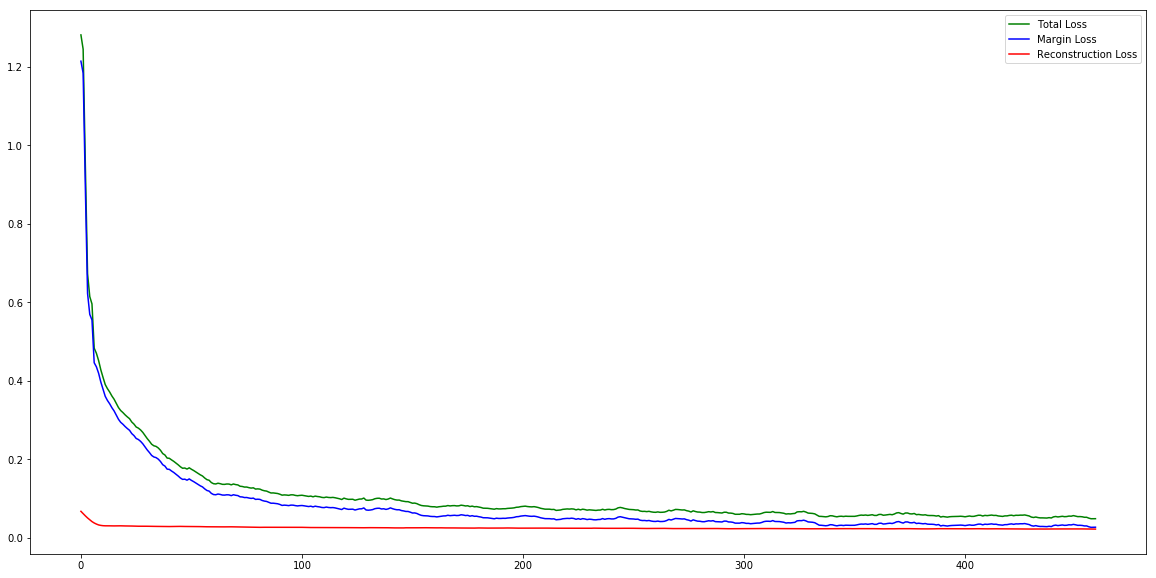

In [26]:
%matplotlib inline
n_points_avg = 10
n_points_plot = 1000
plt.figure(figsize=(20, 10))

curve = np.asarray(history['loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-g')

curve = np.asarray(history['margin_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-b')

curve = np.asarray(history['reconstruction_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-r')

plt.legend(['Total Loss', 'Margin Loss', 'Reconstruction Loss'])


Example:


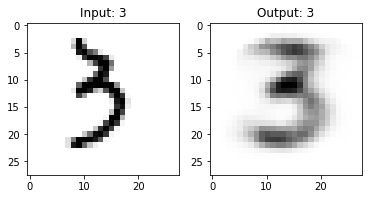

In [27]:
print('Example:')
idx = np.random.randint(0, len(x))
show_example(model, x[idx], y[idx], x_reconstruction[idx], y_pred[idx])